# INFO 2950 Group Project


In [56]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
from matplotlib import pyplot as plt
import duckdb, sqlalchemy

from sklearn.linear_model import LogisticRegression


In [57]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Research Question

Are property characteristics or host characteristics more impactful on the review score of an Airbnb listing?

## Data collection and cleaning

We store a raw dataset as a DataFrame and examine its shape and size.

In [58]:
raw_data_df = pd.read_csv('New_York.csv')
print(raw_data_df.shape)
print(raw_data_df.size)
raw_data_df.head()

(44317, 31)
1373827


,id,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,...,maximum_nights,calendar_updated,availability_30,number_of_reviews,review_scores_rating,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,reviews_per_month
0,18461891,NaN,NaN,f,t,Ditmars Steinway,40.774142,-73.916246,t,Apartment,...,6,5 months ago,0,0,NaN,f,f,strict,f,NaN
1,20702398,within an hour,100%,f,t,City Island,40.849191,-73.786509,f,House,...,21,2 weeks ago,19,2,100.0,f,f,moderate,f,2.00
2,6627449,within an hour,100%,f,t,City Island,40.849775,-73.786609,t,Apartment,...,21,2 weeks ago,28,21,95.0,f,f,strict,f,0.77
3,19949243,within a few hours,100%,f,t,City Island,40.848838,-73.782276,f,Boat,...,1125,6 days ago,30,0,NaN,t,f,strict,f,NaN
4,1886820,NaN,NaN,f,t,City Island,40.841144,-73.783052,t,House,...,90,16 months ago,30,0,NaN,f,f,strict,f,NaN


The dataset is downloaded from Kaggle (URl: https://www.kaggle.com/datasets/ivanovskia1/nyc-airbnb-rental-data-october-2017/versions/1?resource=download). We use NYC Airbnb Rental data in October 2017 as our sample to anaylze whether property characteristics or host characterisitics play a more important role in the review score of an Airbnb listing in NYC. The raw dataframe has 44317 rows and 31 columns. The size of the dataframe is 1373827, which is too big and contains some irrelevant information, so we need to clean it first. 

In [59]:
raw_data_df.isnull().sum()

id                                   0
host_response_time               13679
host_response_rate               13679
host_is_superhost                  232
host_has_profile_pic               232
neighbourhood_cleansed               0
latitude                             0
longitude                            0
is_location_exact                    0
property_type                        0
room_type                            0
accommodates                         0
bathrooms                          144
bedrooms                            73
beds                                91
bed_type                             0
amenities                            0
square_feet                      43768
price                                0
guests_included                      0
minimum_nights                       0
maximum_nights                       0
calendar_updated                     0
availability_30                      0
number_of_reviews                    0
review_scores_rating     

Our research question is centered around the property characteristics and host characteristics of Airbnb rentals, so our first step in cleaning the data was to drop columns that we deemed irrelevant, such as id and calendar updates. Other characteristics like longitude and latitude were too specific for a general audience, as opposed to the general location characteristic. Square footage of the listing would be a beneficial characteristic to include, but after checking the null value, we found that 43768 of the listings do not contain this information, which is 98.7% of our total listings, so we decided to drop it. Finally, given our research question, we chose to include location, property type, and price for property characteristics, and use host response time, host response rate, and cancellation policy for the primary host characteristics. We also need to use review scores rating as our output variable. Furthermore, all other columns will be removed, as we deemed them irrelevant to our research question. 

In [60]:
%sql data_df << SELECT neighbourhood_cleansed AS location, property_type, price, host_response_time, host_response_rate, cancellation_policy, review_scores_rating FROM raw_data_df
print(data_df.shape)
print(data_df.size)
data_df.head()

Returning data to local variable data_df
(44317, 7)
310219


,location,property_type,price,host_response_time,host_response_rate,cancellation_policy,review_scores_rating
0,Ditmars Steinway,Apartment,110,None,None,strict,NaN
1,City Island,House,50,within an hour,100%,moderate,100.0
2,City Island,Apartment,125,within an hour,100%,strict,95.0
3,City Island,Boat,100,within a few hours,100%,strict,NaN
4,City Island,House,300,None,None,strict,NaN


We need to further clean the dataset as there are some NaN values for host response time, host response rate and review score rating. We decide to remove rows that contain missing data. We choose to remove incomplete data instead of filling in numbers for missing data because about 31% of the rows do not contain a value for host response time and host response rate, and about 22% of the rows do not contain a value for the review score. We think if we simply fill the missing value with zeros, it will create a strong bias during our sample analysis. Our raw dataset is very large, so removing the raws can still lead to a reliable and consistent dataset.

In [61]:
%sql airbnb_df << SELECT* FROM data_df WHERE review_scores_rating is not null and host_response_time is not null and host_response_rate is not null
print(airbnb_df.shape)
print(airbnb_df.size)
airbnb_df.head()

Returning data to local variable airbnb_df
(26620, 7)
186340


,location,property_type,price,host_response_time,host_response_rate,cancellation_policy,review_scores_rating
0,City Island,House,50,within an hour,100%,moderate,100.0
1,City Island,Apartment,125,within an hour,100%,strict,95.0
2,City Island,House,69,within an hour,100%,moderate,97.0
3,City Island,Apartment,150,within an hour,100%,flexible,100.0
4,City Island,House,101,within an hour,100%,moderate,100.0


In [62]:
airbnb_df.isnull().sum()

location                0
property_type           0
price                   0
host_response_time      0
host_response_rate      0
cancellation_policy     0
review_scores_rating    0
dtype: int64

At this point, our data is in good quality. The clean dataframe has 26620 rows and 7 columns. The size of the dataframe is 186340, which is a large, representative dataset for our analysis. We are ready to explore the dataset further. The cleaned data is exported as cleaned_airbnb_data.csv.

In [63]:
airbnb_df.to_csv('cleaned_airbnb_data.csv')

## Data description

The data source we used is https://www.kaggle.com/datasets/ivanovskia1/nyc-airbnb-rental-data-october-2017?resource=download. Our cleaned data contains 26620 properties and the data was accumulated in New York, NY in October 2017.

This consists of information to find out about hosts, geographical and property characteristic information used to make predictions and draw conclusions. Specifically, the observations in our data are the different Airbnb properties listed in New York City in October 2017 and the attributes are host response time, response rate, host cancellation policy, location, property type, price, and review score rating. These variables will then all be used to answer our research question regarding whether host characteristics or property characteristics impact Airbnb reviews more.  

This data was sourced from a website with Airbnb data known as Inside Airbnb. The Inside Airbnb is a mission-driven project that provides data and advocacy about Airbnb's impact on residential communities. Donations fund the collection and hosting of data, the development of analytic and activist tools, and help sustain the project. Subsequently, the data collected may have been biased towards data that shows Airbnb listings which are entire homes, showing its impact on the housing market. The Airbnb's which disrupt the hotel industry or which are property such as boats were probably less likely to be recorded.

This data was then taken from the Inside Airbnb website and got cleaned and processed into a dataset and then uploaded on kaggle. This is the dataset that was downloaded and used in this project. The people involved in the data were not aware about the study, the data about them was sourced by taking the information off the publicly available Airbnb website and compiling it. 

Link to the raw data here: https://drive.google.com/file/d/1XSb32p2DSTveb-4yvYIPQPTCIuojQ3f6/view?usp=sharing


In [64]:
variable_types = airbnb_df.dtypes
print('Here are the types of each of the variables:')
print(variable_types)

Here are the types of each of the variables:
location                 object
property_type            object
price                     int64
host_response_time       object
host_response_rate       object
cancellation_policy      object
review_scores_rating    float64
dtype: object


The descriptions of each of the variables are: 
- location: represents the neighborhood in New York the property is located
- property_type: represents the type of Airbnb being rented for example a house, apartment or boat
- price: represents the nightly rate of the property
- host_response_time: the average time a host takes to respond
- host_response_rate: the percentage of times a host responds to a booking request
- cancellation_policy: whether the host's policy is strict or flexible (should we change this to boolean?)
- review_scores_rating: the Airbnb rating on a scale of 0-100

## Data limitations

One of the major limitations of this study is that there are a lot of fake ratings. For example, hosts will sometimes rate their own property or ask others to do it to increase the percentage of their review score. This will lead to bias in the model since some of the Airbnb's results are not an accurate representation of what people think about the listing. This leads to some bias in our data of the success of some properties being exaggerated. 

Secondly, a large number of properties had very few reviews or none at all. We removed the properties without a review score from our data when we cleaned it but this means we did not account for several of the listings available in NYC and we still have the properties with few ratings. Also, it is proven that people are more likely to leave a review if it's a negative experience.This means that the results are likely skewed where properties with lower ratings are more likely to have been in our sample since we removed the properties with no ratings.

Additionally, to draw our conclusions, we have to make assumptions about what characteristics make a good host and narrow down which ones really differentiate a property. We chose response rate, cancellation policy, and response time to be the ones that determine a good host but there may be missing characteristics that impact the success of a host. Similarly, we narrowed it down to location, property type, and price for the property attributes; however, many other things could be impacting the Airbnb listing which are not accounted for.

## Exploratory data analysis

### Summary Statistics

The first step in exploratory data analysis was to calculate summary functions for some of the relevant variables. This includes the standard deviation and mean for numerical values for the property characteristics mainly price and host characteristics mainly response time compared to the review scores.

We will then analyze how review scores also vary to get a general idea of the average review and the standard deviation.

In [95]:
from statistics import mean, median, mode, stdev

price_mean = airbnb_df['price'].mean()
print('Mean of price: ' + str(price_mean))
price_std = airbnb_df['price'].std()
print('Standard deviation of price: ' + str(price_std))

airbnb_df['host_response_rate'] = airbnb_df['host_response_rate'].astype('str') 
airbnb_df['host_response_rate'] = airbnb_df['host_response_rate'].str.rstrip('%').astype('float')/100
response_rate_mean = airbnb_df['host_response_rate'].mean()
print('Mean of response: ' + str(response_rate_mean))
response_rate_mean_std = airbnb_df['host_response_rate'].std()
print('Standard deviation of response rate: ' + str(response_rate_mean_std))

review_scores_mean = airbnb_df['review_scores_rating'].mean()
print('Mean of reviews: ' + str(review_scores_mean))
review_scores_std = airbnb_df['review_scores_rating'].std()
print('Standard deviation of reviews: ' + str(review_scores_std ))

Mean of price: 143.84830954169797
Standard deviation of price: 173.79921548824515
Mean of response: 9.46408339593934e-11
Standard deviation of response rate: 1.472526239574421e-11
Mean of reviews: 93.65638617580767
Standard deviation of reviews: 7.469818466605432



As for the property characteristics we calculated the average nightly rate for an Airbnb rental was \\$143.85, and that the standard deviation was significantly high at \\$173.80. This indicated that there is drastic variation in the nightly rates of Airbnb rentals. This was to be expected as the minimum nightly rate in our dataset was \\$0 , and the max was \\$10,000. Excluding such outliers the most common low nightly rates were around \\$ 40 a night and the most common high nightly rates were around \$400 a night. Despite the outliers this would still be a high standard deviation and therefore there still a relatively large spread in nightly rates.

As for the host characteristics the mean was 95% and the standard deviation was significantly low at 0.14. If a host reponds to all guest messages at some point their response rate is 100%, and if they never respond to guests their response rate is 0%. The mean and standard deviataion indicate that almost all hosts responded to guests messages at some point, and having a host not respond to a few guests was extremely rare. 

As for the review scores, the mean was 93.66 and the standard deviation was 7.47. The mean scores are very high as guests tended to enjoy the rentals they stayed at. The standard deviation is very high as well, indicating that there was large fluctuation in property ratings. Despite this variation, it was very rare for ratings to fall below 80%. 

At this stage, while this information is useful, we are interested in finding more data which can further provide better analysis and answer our research question of whether the property or the host is more impactful on property reviews.


### Visual displays

### Property Characteristics

The next step in our exploratory data was to create a histogram to further analyze the data visually. For the first histogram we decided to compare the review scores vs. price. This will determine whether a relationship exists between review scores and price.

Before doing so, we need to inspect whether there is any outlier in price by drawing a boxplot. We need to think about how to deal with outliers with extremely high price that might create a bias for our model. 


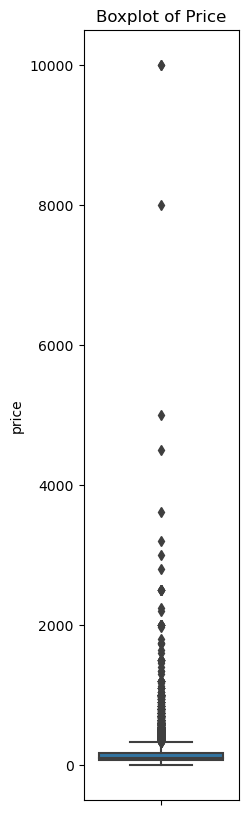

In [66]:
pyplot.figure(figsize=(2,10))
seaborn.boxplot(y ='price', data=airbnb_df)
pyplot.title('Boxplot of Price')
pyplot.show()

From the boxplot, we can see that the 25 percentile, 50 percentile, and 75 percentile are all far below 2000. There are some outliers at approximately \\$10000, \\$8000, and \\$2000-\\$5000 range. These extremely large numbers do not look representative of our population, and it is possible that the property owners list these price intentionally to prevent booking. Thus, it is worth considering excluding these numbers. If we exclude these numbers, the mean and standard deviation of price will both decrease. 

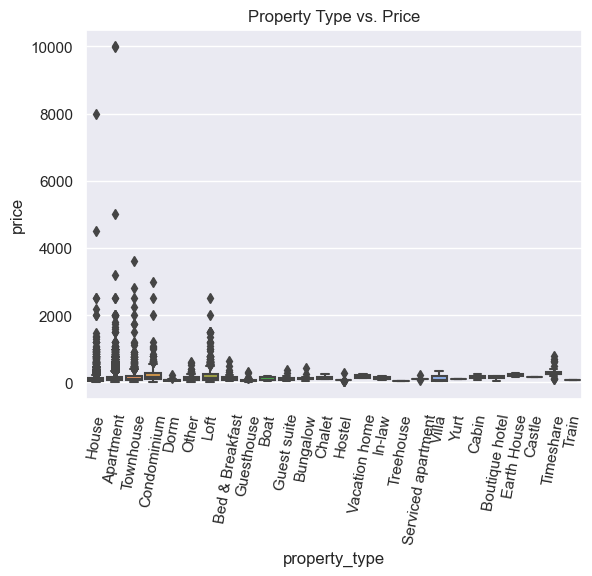

In [99]:
airbnb_df['property_type'].groupby(by=airbnb_df['property_type']).describe()
seaborn.boxplot(x='property_type', y='price', data=airbnb_df)
pyplot.title('Property Type vs. Price')
pyplot.xticks(rotation = 80)
pyplot.show()


From this boxplot, we can see that there is there is a strong relationship between rental rate and the type of house. The relationship between the two variables indicates that certain property types have higher prices associated with them. Houses for example are priced much higher than smaller units such as dorms and hostels. What we found interesting in this visual graph is that apartments are priced similarly to houses, of which both are priced high.

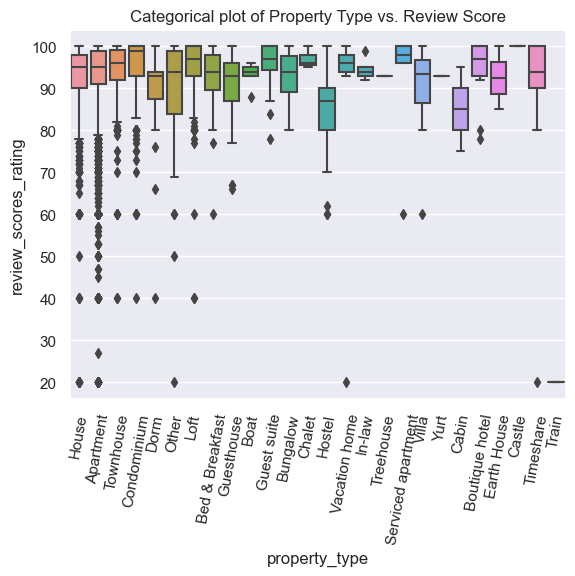

In [100]:
seaborn.boxplot(x='property_type', y='review_scores_rating', data=airbnb_df)
pyplot.title('Categorical plot of Property Type vs. Review Score')
pyplot.xticks(rotation = 80)
pyplot.show()


From this boxplot, we can see that there is a relationship between property type and review score. For some property types, such as hostel, dorm, and cabin, the owners tend to receive a lower review rating, whereas apartment, loft, townhouse and etc. tend to have higher review rating. This indicates that there is a strong relationship between not only the type of property and price, but also the type of property and review score.


### Model 

Finally we decided to create a linear regression model in order to calculate and compare the strength in the relationship between the property characteristics and reviews, as well as the host characteristics and reviews. The variable we used for the property characteristics was the price, and the variable we used for the host characteristics was the response rate. 

The linear regression models demonstrated a broad relationship between property characteristics and reviews, and host characteristics and reviews. 

While calculating the summary statistics, visual displays and regression models brought us closer to answering our research question on whether property characteristics or host characteristics are more impactful on review scores, more in depth analysis would be beneficial in solidifying a conclusion. 


## Questions for reviewers

- Should we assign values to the response rates in order to calculate summary functions? (current values are “within one hour”, “within one week”…)
- This dataset only includes samples from NYC rentals, can we conclude our findings as a basis for all Airbnb rentals, or do we have to specify it is only NYC rentals? 
- When writing descriptions discussing the processes we followed (such as how we cleaned our data), is the standard to write in the present tense or past tense? 